In [18]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
path = str(Path.cwd().parent)
print(path)
sys.path.insert(1, path)

import numpy as np
import pandas as pd
import skforecast

print(skforecast.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/joaquin/Documents/GitHub/skforecast
0.20.0


In [19]:
# Libraries
# ==============================================================================
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from skforecast.datasets import fetch_dataset
from skforecast.stats import Arima, Sarimax
from skforecast.recursive import ForecasterStats
from skforecast.model_selection import TimeSeriesFold, backtesting_stats
from skforecast.utils import expand_index
from skforecast.plot import set_dark_theme, plot_prediction_intervals
from pmdarima import auto_arima
import warnings

set_dark_theme()
warnings.filterwarnings('once')
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [20]:
# Datasets
# ==============================================================================
from fixtures_arima import datasets

# Monthly expenditure ($AUD) on corticosteroid drugs  Hyndman R (2023). fpp3

In [4]:
data = datasets['h2o_data']['data'].to_frame(name='y')
data.head()

,y
1992-04-01,0.379808
1992-05-01,0.361801
1992-06-01,0.410534
1992-07-01,0.483389
1992-08-01,0.475463


Train dates : 1992-04-01 00:00:00 --- 2005-06-01 00:00:00  (n=159)
Test dates  : 2005-07-01 00:00:00 --- 2008-06-01 00:00:00  (n=36)


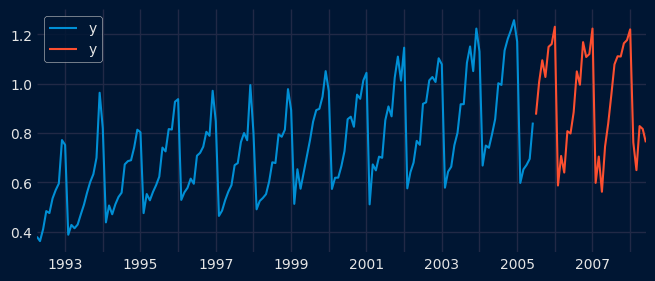

In [5]:
# Train-test dates
# ==============================================================================
end_train = '2005-06-01 23:59:59'

print(
    f"Train dates : {data.index.min()} --- {data.loc[:end_train].index.max()}  "
    f"(n={len(data.loc[:end_train])})"
)
print(
    f"Test dates  : {data.loc[end_train:].index.min()} --- {data.loc[:].index.max()}  "
    f"(n={len(data.loc[end_train:])})"
)

data_train = data.loc[:end_train]
data_test  = data.loc[end_train:]

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data_train.plot(ax=ax)
data_test.plot(ax=ax)
ax.legend();

## Statsmodels and pmdArima

In [6]:
# Statsmodels SARIMAX
# ==============================================================================
model = Sarimax(order=(1, 1, 0), seasonal_order=(1, 0, 0, 12))
model.fit(y=data_train['y'])
display(model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  159
Model:             SARIMAX(1, 1, 0)x(1, 0, 0, 12)   Log Likelihood                 219.239
Date:                            Sat, 31 Jan 2026   AIC                           -432.478
Time:                                    09:50:57   BIC                           -423.290
Sample:                                04-01-1992   HQIC                          -428.747
                                     - 06-01-2005                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5003      0.060     -8.351      0.000      -0.618      -0.383
ar.S.L12       0.9459      0.016     58.173      0.000       0.914       0.978
sigma2         0.0031      0.000     10.218      0.000       0.002       0.004
===================================================================================
Ljung-Box (L1) (Q):                   3.25   Jarque-Bera (JB):                 8.52
Prob(Q):                              0.07   Prob(JB):                         0.01
Heteroskedasticity (H):               1.56   Skew:                            -0.42
Prob(H) (two-sided):                  0.11   Kurtosis:                         3.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

,pred,lower_bound,upper_bound
2005-07-01,0.934859,0.826242,1.043475
2005-08-01,0.950690,0.829269,1.072112
2005-09-01,1.071606,0.925389,1.217823


Test error (mae): 0.09556716303459602


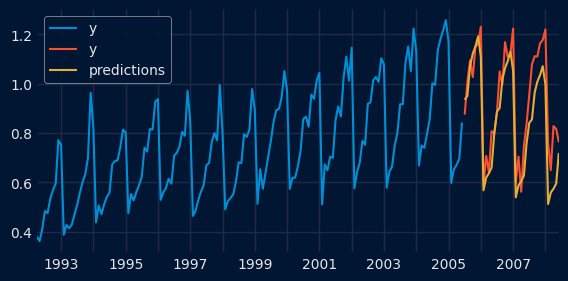

In [7]:
predictions = model.predict(
    steps=len(data_test), return_conf_int=True, alpha=0.05
)
display(predictions.head(3))

error_mae = mean_absolute_error(
                y_true = data_test, 
                y_pred = predictions['pred']
            )
print(f"Test error (mae): {error_mae}")

fig, ax = plt.subplots(figsize=(6, 3))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
predictions['pred'].plot(ax=ax, label='predictions')
ax.legend();

In [8]:
res = auto_arima(
            y=data_train,
            start_p=0,
            start_q=0,
            max_p=5,
            max_q=5,
            max_P=2,
            max_D=1,
            max_Q=2,
            seasonal=True,
            information_criterion="aic",
            test="kpss",
            m=12,
            d=None,
            D=None,
            trace=True,
            n_fits=94,
            method="bfgs",
            maxiter=500,
            error_action="ignore",
            suppress_warnings=True,
            stepwise=True,
        )

predictions_best_model = res.predict(n_periods=len(data_test))
error_mae = mean_absolute_error(
                y_true = data_test, 
                y_pred = predictions_best_model
            )
print(f"Test error (mae) of best model: {error_mae}")

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=-422.149, Time=3.09 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-407.412, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-434.283, Time=0.53 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-434.120, Time=1.72 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-364.201, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=-429.024, Time=0.37 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=-440.273, Time=1.64 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=-449.514, Time=7.27 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=-448.255, Time=2.76 sec
 ARIMA(1,0,0)(2,1,2)[12] intercept   : AIC=-446.008, Time=11.31 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=-448.047, Time=6.60 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=-420.575, Time=2.05 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=-463.412, Time=8.79 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=-461.863, Time=5.21 sec
 ARIMA(2,0,0)(2,1,

## Skforecast

In [9]:
# ARIMA model with skforecast Arima classs
# ==============================================================================
model = Arima(order=(1, 1, 0), seasonal_order=(1, 1, 0), m=12, optim_kwargs={"maxiter": 10000})
model.fit(y=data_train['y'])
display(model.summary())

ARIMA Model Summary
Model     : Arima(1,1,0)(1,1,0)[12]
Method    : ARIMA(1,1,0)(1,1,0)[12]
Converged : False

Coefficients:
------------------------------------------------------------
  ar1            :    -0.5459  (SE:   0.0690, t:    -7.91)
  sar1           :    -0.2359  (SE:   0.0844, t:    -2.79)

Model fit statistics:
  sigma^2:             0.002961
  Log-likelihood:      216.84
  AIC:                 -427.69
  BIC:                 N/A

Residual statistics:
  Mean:                -0.001118
  Std Dev:             0.052293
  MAE:                 0.038330
  RMSE:                0.052141

Time Series Summary Statistics:
Number of observations: 159
  Mean:                 0.7471
  Std Dev:              0.2068
  Min:                  0.3618
  25%:                  0.5781
  Median:               0.7254
  75%:                  0.8955
  Max:                  1.2572


/home/joaquin/Documents/GitHub/skforecast/skforecast/stats/arima/_arima_base.py:2521: UserWarning: Possible convergence problem. Try to increase 'maxiter' or change the optimization method.
  warnings.warn(


None

,mean,lower_95,upper_95
2005-07-01,0.932115,0.814986,1.049244
2005-08-01,0.953329,0.811369,1.095290
2005-09-01,1.085231,0.929974,1.240488


Test error (mae): 0.0749586396682487


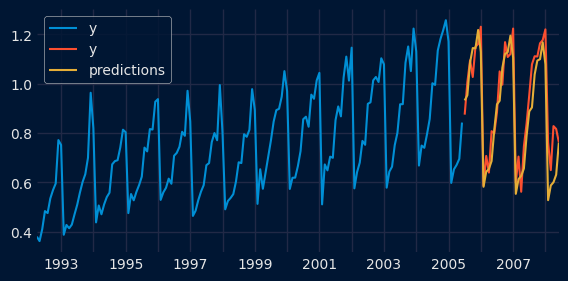

In [10]:
predictions = model.predict_interval(
    steps=len(data_test), alpha=0.05
)
predictions.index = data_test.index
display(predictions.head(3))


error_mae = mean_absolute_error(
                y_true = data_test, 
                y_pred = predictions['mean']
            )
print(f"Test error (mae): {error_mae}")

fig, ax = plt.subplots(figsize=(6, 3))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
predictions['mean'].plot(ax=ax, label='predictions')
ax.legend();

In [12]:
res = Arima(
            order=None,
            seasonal_order=None,
            start_p=0,
            start_q=0,
            max_p=5,
            max_q=5,
            max_P=2,
            max_Q=2,
            max_order=5,
            max_d=2,
            max_D=1,
            ic="aic",
            seasonal=True,
            test="kpss",
            nmodels=94,
            optim_method="BFGS",
            m=12,
            trace=True,
            stepwise=True,
        )
res.fit(y=data_train['y'], suppress_warnings=True)
predictions_best_model = res.predict(steps=len(data_test))
error_mae = mean_absolute_error(
                y_true = data_test, 
                y_pred = predictions_best_model
            )
print(f"Test error (mae) of best model: {error_mae}")


Fitting models using approximations...

 ARIMA(p,d,q)(P,D,Q)[m]                     : aic
 ARIMA(0,0,0)(1,1,1)[12] with drift         : -421.1032
 ARIMA(0,0,0)(0,1,0)[12] with drift         : -406.4090
 ARIMA(1,0,0)(1,1,0)[12] with drift         : -433.3090
 ARIMA(0,0,1)(0,1,1)[12] with drift         : -433.0979
 ARIMA(0,0,0)(0,1,0)[12]                    : -363.4369
 ARIMA(1,0,0)(0,1,0)[12] with drift         : -428.0812
 ARIMA(1,0,0)(2,1,0)[12] with drift         : -438.7458
 ARIMA(1,0,0)(2,1,0)[12]                    : -417.2979
 ARIMA(1,0,0)(2,1,1)[12] with drift         : -447.8319
 ARIMA(1,0,0)(2,1,1)[12]                    : Inf
 ARIMA(1,0,0)(1,1,1)[12] with drift         : -446.8850
 ARIMA(1,0,0)(2,1,2)[12] with drift         : -446.5534
 ARIMA(1,0,0)(1,1,2)[12] with drift         : Inf
 ARIMA(0,0,0)(2,1,1)[12] with drift         : -419.4777
 ARIMA(2,0,0)(2,1,1)[12] with drift         : -462.1904
 ARIMA(2,0,0)(2,1,1)[12]                    : -450.8349
 ARIMA(2,0,0)(1,1,1)[12] 

# Monthly fuel consumption in Spain

In [21]:
data = datasets['fuel_consumption']['data'].to_frame(name='y')
data.head()

,y
1969-01-01,166875.2129
1969-02-01,155466.8105
1969-03-01,184983.6699
1969-04-01,202319.8164
1969-05-01,206259.1523


Train dates : 1969-01-01 00:00:00 --- 1980-01-01 00:00:00  (n=133)
Test dates  : 1980-02-01 00:00:00 --- 1990-01-01 00:00:00  (n=120)


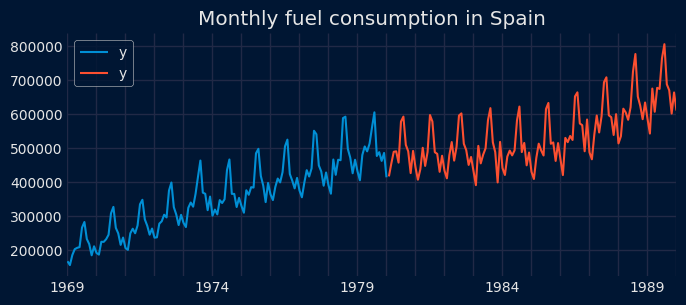

In [ ]:
# Split data in train-test partitions
# ======================================================================================
end_train = '1983-01-01 23:59:59'

print(
    f"Train dates : {data.index.min()} --- {data.loc[:end_train].index.max()}  "
    f"(n={len(data.loc[:end_train])})"
)
print(
    f"Test dates  : {data.loc[end_train:].index.min()} --- {data.loc[:].index.max()}  "
    f"(n={len(data.loc[end_train:])})"
)

data_train = data.loc[:end_train]
data_test  = data.loc[end_train:]

# Plot
# ======================================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
ax.set_title('Monthly fuel consumption in Spain')
ax.legend();

In [23]:
# Statsmodels SARIMAX
# ==============================================================================
model = Sarimax(order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model.fit(y=data_train['y'])
display(model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  133
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1356.051
Date:                            Sat, 31 Jan 2026   AIC                           2722.103
Time:                                    10:16:41   BIC                           2736.040
Sample:                                01-01-1969   HQIC                          2727.763
                                     - 01-01-1980                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4972      0.134     -3.707      0.000      -0.760      -0.234
ma.L1         -0.0096      0.146     -0.066      0.947      -0.295       0.276
ar.S.L12       0.0465      0.162      0.288      0.774      -0.270       0.364
ma.S.L12      -0.3740      0.203     -1.847      0.065      -0.771       0.023
sigma2      3.291e+08   1.06e-09    3.1e+17      0.000    3.29e+08    3.29e+08
===================================================================================
Ljung-Box (L1) (Q):                   5.13   Jarque-Bera (JB):                18.12
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               1.26   Skew:                            -0.42
Prob(H) (two-sided):                  0.46   Kurtosis:                         4.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.04e+34. Standard errors may be unstable.
"""

,pred,lower_bound,upper_bound
1980-02-01,407504.056939,371949.705072,443058.408805
1980-03-01,473997.245807,434354.329995,513640.161620
1980-04-01,489983.091486,442301.898919,537664.284053


Test error (mae): 37141.03689402891


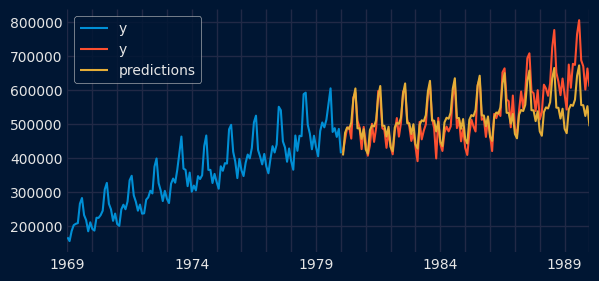

In [24]:
predictions = model.predict(
    steps=len(data_test), return_conf_int=True, alpha=0.05
)
display(predictions.head(3))

error_mae = mean_absolute_error(
                y_true = data_test, 
                y_pred = predictions['pred']
            )
print(f"Test error (mae): {error_mae}")

fig, ax = plt.subplots(figsize=(6, 3))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
predictions['pred'].plot(ax=ax, label='predictions')
ax.legend();

In [28]:
res = auto_arima(
            y=data_train,
            start_p=0,
            start_q=0,
            max_p=5,
            max_q=5,
            max_P=2,
            max_D=1,
            max_Q=2,
            seasonal=True,
            information_criterion="aic",
            test="kpss",
            m=12,
            d=None,
            D=None,
            trace=True,
            n_fits=94,
            method="bfgs",
            maxiter=500,
            error_action="ignore",
            suppress_warnings=True,
            stepwise=True,
        )

predictions_best_model = res.predict(n_periods=len(data_test))
error_mae = mean_absolute_error(
                y_true = data_test, 
                y_pred = predictions_best_model
            )
print(f"Test error (mae) of best model: {error_mae}")

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=3.81 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2741.493, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2744.556, Time=0.40 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=2744.384, Time=0.28 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2872.055, Time=0.02 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=2743.148, Time=0.14 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=2742.954, Time=0.15 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=2743.258, Time=0.04 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=2743.270, Time=0.05 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=2743.157, Time=0.07 sec

Best model:  ARIMA(0,0,0)(0,1,0)[12] intercept
Total fit time: 5.007 seconds
Test error (mae) of best model: 106027.10875389095


In [30]:
# ARIMA model with skforecast Arima classs
# ==============================================================================
model = estimator=Arima(order=(1, 1, 1), seasonal_order=(1, 1, 1), m=12)
model.fit(y=data_train['y'])
display(model.summary())

ARIMA Model Summary
Model     : Arima(1,1,1)(1,1,1)[12]
Method    : ARIMA(1,1,1)(1,1,1)[12]
Converged : False

Coefficients:
------------------------------------------------------------
  ar1            :    -0.4401  (SE:   0.1521, t:    -2.89)
  ma1            :    -0.4175  (SE:   0.1828, t:    -2.28)
  sar1           :    -0.3349  (SE:   0.1458, t:    -2.30)
  sma1           :    -0.3588  (SE:   0.1314, t:    -2.73)

Model fit statistics:
  sigma^2:             222657174.677695
  Log-likelihood:      -1327.26
  AIC:                 2664.52
  BIC:                 N/A

Residual statistics:
  Mean:                -427.900183
  Std Dev:             14220.799122
  MAE:                 9952.037613
  RMSE:                14173.697169

Time Series Summary Statistics:
Number of observations: 133
  Mean:                 356999.6602
  Std Dev:              102097.7181
  Min:                  155466.8105
  25%:                  273259.5482
  Median:               362402.1589
  75%:              

/home/joaquin/Documents/GitHub/skforecast/skforecast/stats/arima/_arima_base.py:2521: UserWarning: Possible convergence problem. Try to increase 'maxiter' or change the optimization method.
  warnings.warn(


None

,mean,lower_95,upper_95
1980-02-01,422832.029235,393290.988766,452373.069703
1980-03-01,486532.072686,453308.979645,519755.165728
1980-04-01,487972.176020,453175.751743,522768.600296


Test error (mae): 55783.731433458546


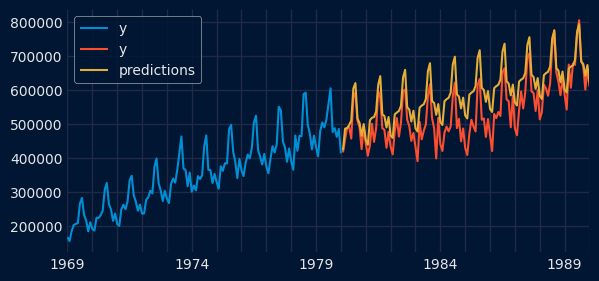

In [31]:
predictions = model.predict_interval(
    steps=len(data_test), alpha=0.05
)
predictions.index = data_test.index
display(predictions.head(3))


error_mae = mean_absolute_error(
                y_true = data_test, 
                y_pred = predictions['mean']
            )
print(f"Test error (mae): {error_mae}")

fig, ax = plt.subplots(figsize=(6, 3))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
predictions['mean'].plot(ax=ax, label='predictions')
ax.legend();

In [32]:
res = Arima(
            order=None,
            seasonal_order=None,
            start_p=0,
            start_q=0,
            max_p=5,
            max_q=5,
            max_P=2,
            max_Q=2,
            max_order=5,
            max_d=2,
            max_D=1,
            ic="aic",
            seasonal=True,
            test="kpss",
            nmodels=94,
            optim_method="BFGS",
            m=12,
            trace=True,
            stepwise=True,
        )
res.fit(y=data_train['y'], suppress_warnings=True)
predictions_best_model = res.predict(steps=len(data_test))
error_mae = mean_absolute_error(
                y_true = data_test, 
                y_pred = predictions_best_model
            )
print(f"Test error (mae) of best model: {error_mae}")

 ARIMA(0,0,0)(1,1,1)[12] with drift         : 2705.6134
 ARIMA(0,0,0)(0,1,0)[12] with drift         : 2742.4671
 ARIMA(1,0,0)(1,1,0)[12] with drift         : 2711.7465
 ARIMA(0,0,1)(0,1,1)[12] with drift         : 2705.5029
 ARIMA(0,0,0)(0,1,0)[12]                    : 2871.9907
 ARIMA(0,0,1)(0,1,0)[12] with drift         : 2743.9402
 ARIMA(0,0,1)(1,1,1)[12] with drift         : 2704.7817
 ARIMA(0,0,1)(1,1,1)[12]                    : Inf
 ARIMA(0,0,1)(1,1,0)[12] with drift         : 2712.8837
 ARIMA(0,0,1)(2,1,1)[12] with drift         : Inf
 ARIMA(0,0,1)(1,1,2)[12] with drift         : Inf
 ARIMA(0,0,1)(0,1,2)[12] with drift         : 2702.3991
 ARIMA(0,0,1)(0,1,2)[12]                    : Inf
 ARIMA(0,0,0)(0,1,2)[12] with drift         : Inf
 ARIMA(1,0,1)(0,1,2)[12] with drift         : Inf
 ARIMA(0,0,2)(0,1,2)[12] with drift         : 2679.3956
 ARIMA(0,0,2)(0,1,2)[12]                    : Inf
 ARIMA(0,0,2)(0,1,1)[12] with drift         : 2686.4991
 ARIMA(0,0,2)(1,1,2)[12] with drif